In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import visuals as vs

In [27]:
# /kaggle/input/titanic/
titanic_df = pd.read_csv("train.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [29]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

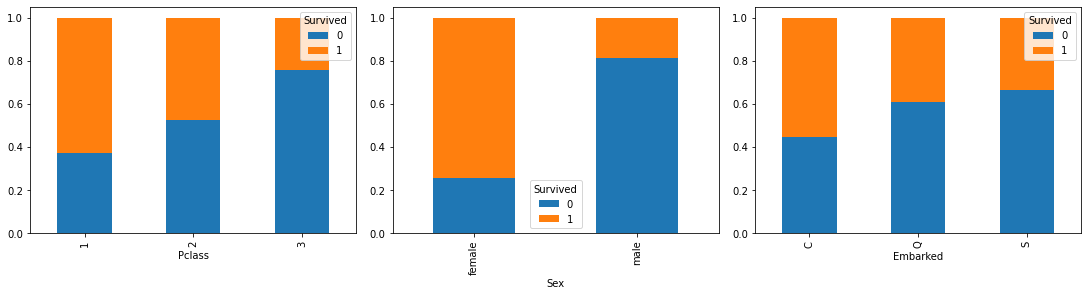

In [30]:
vs.visualize_crosstabs(titanic_df, ['Pclass', 'Sex','Embarked'], 'Survived')

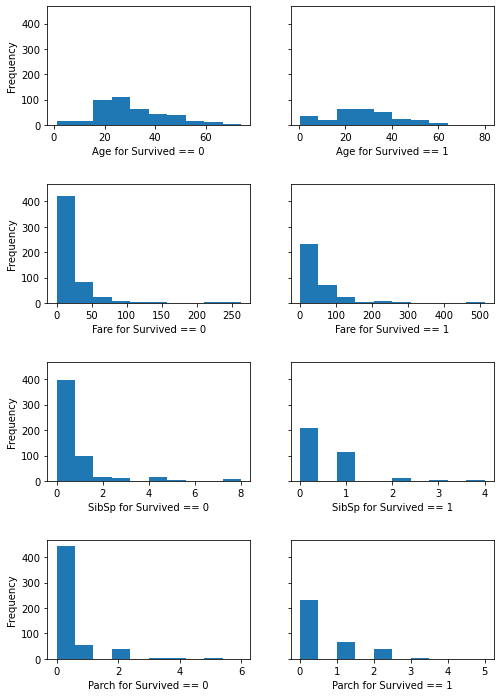

In [31]:
vs.visualize_numerical_feature(titanic_df, ['Age', 'Fare', 'SibSp', 'Parch'], 'Survived')

## Data Precprocessing

In [32]:
class TitanicDataPreProccessor:
    def __init__(self):
        # Normalize numeric columns
        from sklearn.preprocessing import StandardScaler
        self.std_scaler = StandardScaler()
        
    def _fill_empty_with_average(self, df, column: str, critieria_column: str):
         # Fill empty Age cells
        if df[column].isnull().sum() == 0:
            return
        
        values = df[critieria_column].unique()
        for v in values:
            mask = (titanic_df[critieria_column] == v)
            mean = titanic_df[mask][column].mean()
            print(f"Mean {v} {column} is {mean}")
            df.loc[mask & (df[column].isnull()), column] = mean
    

    def preprocess_data(self, titanic_df: pd.DataFrame) -> pd.DataFrame:
        """ Perform all data preprocessing in one function in order to apply in one step later on testing data

        Inputs:
            df: dataframe

        Returns:
            DataFrame
        """
        # drop empty Embarked row
        mask = titanic_df['Embarked'].isnull()
        titanic_df[mask]

        # Fill empty Age cells
        self._fill_empty_with_average(titanic_df, 'Age', 'Sex')
        self._fill_empty_with_average(titanic_df, 'Fare', 'Pclass')

        # Drop the non-useful colunms
        titanic_df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)


        # OneHotEncode categorical columns
        titanic_df = pd.get_dummies(titanic_df, columns=['Sex', 'Embarked', 'Pclass'])

        titanic_df[['Age', 'Fare', 'SibSp', 'Parch']] = self.std_scaler.fit_transform(
                                                                        titanic_df[['Age','Fare', 'SibSp', 'Parch']])

        return titanic_df.copy()

In [33]:
preproccessor = TitanicDataPreProccessor()
titanic_final = preproccessor.preprocess_data(titanic_df)

Mean male Age is 30.72664459161148
Mean female Age is 27.915708812260537


In [34]:
titanic_final.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,-0.594732,0.432793,-0.473674,-0.502445,0,1,0,0,1,0,0,1
1,1,0.635319,0.432793,-0.473674,0.786845,1,0,1,0,0,1,0,0
2,1,-0.287220,-0.474545,-0.473674,-0.488854,1,0,0,0,1,0,0,1
3,1,0.404684,0.432793,-0.473674,0.420730,1,0,0,0,1,1,0,0
4,0,0.404684,-0.474545,-0.473674,-0.486337,0,1,0,0,1,0,0,1


In [35]:
target = titanic_final['Survived']
features = titanic_final.drop(columns=['Survived'], axis=1)

target.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [36]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=target)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 712 samples.
Testing set has 179 samples.


In [37]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
accuracy = (np.sum(target) + 0) / target.count()
recall = np.sum(target) / np.sum(target)
precision = np.sum(target) / target.count()

g_fscore_beta = 1

# TODO: Calculate F-score using the formula above for beta and correct values for precision and recall.
fscore = ((1.0 + g_fscore_beta*g_fscore_beta) * precision * recall) / (((g_fscore_beta*g_fscore_beta) * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3838, F-score: 0.5547]


In [38]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta = 1
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=g_fscore_beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=g_fscore_beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

KNeighborsClassifier trained on 7 samples.
KNeighborsClassifier trained on 71 samples.
KNeighborsClassifier trained on 712 samples.
XGBClassifier trained on 7 samples.
XGBClassifier trained on 71 samples.
XGBClassifier trained on 712 samples.
SVC trained on 7 samples.
SVC trained on 71 samples.
SVC trained on 712 samples.


d:\github-repos\titanic\visuals.py:127: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


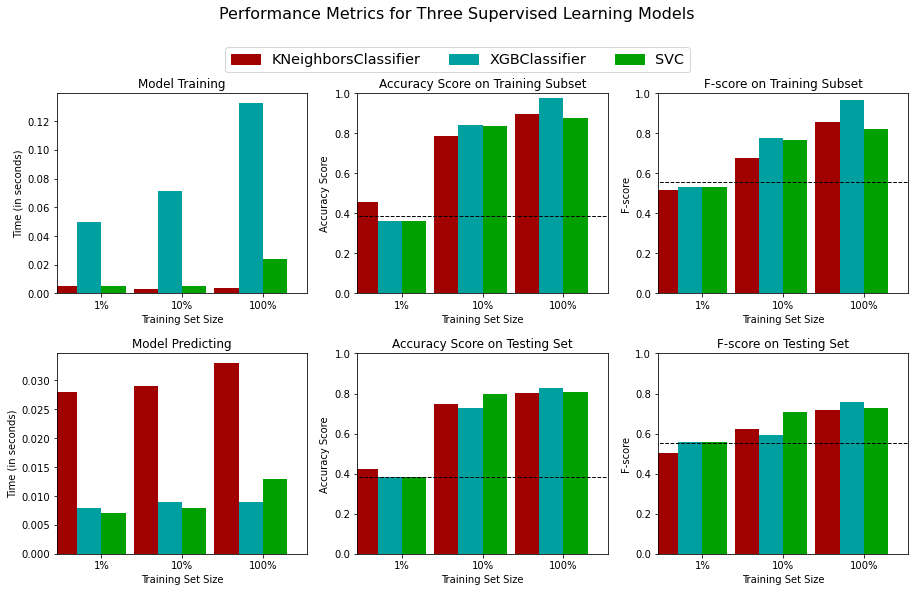

In [39]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVC
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "xgboost")

# # TODO: Initialize the three models
#weights = {0: 0.75, 1: 0.25}
clf_A = KNeighborsClassifier()
clf_B = xgb.XGBClassifier(eval_metric='rmse')
clf_C = SVC(random_state=0)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [40]:
from sklearn.metrics import accuracy_score, fbeta_score

# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
weight = {0: 0.384, 1: 0.616}
clf = xgb.XGBClassifier(eval_metric='rmse', random_state=0)


# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

# Hyperparameters for GradientBoostingClassifier
# parameters = {
#      "n_estimators": [100, 300],
#      "max_depth": [3, 5, 7],
# }

# Hyperparameters for XGBoost
parameters = {
    'eta': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'gamma': [0.1, 0.3, 0.5, 1, 1.5],
}

# Hyperparameters for KNN
# parameters = {
#     'n_neighbors' : [3,5,7,9,11,13,15,20],
#     'weights' : ['uniform','distance'],
#     'metric' : ['minkowski','euclidean','manhattan']}

# Hyperparameters for HistGradientBoostingClassifier
# parameters = {
#     'learning_rate': [0.001, 0.01, 0.1, 1],
#     #'l2_regularization': [0, 1],
# }

# Hyperparameters for LogisticRegression
# parameters = {
#     'penalty': ['l1', 'l2'],
#     'loss': ['modified_huber', 'squared_hinge'],
#     'alpha': [0.0001, 0.001, 0.01, 0.1],
# }

# Hyperparameters for SVC
# parameters = {
#     'C': [0.01, 0.1, 1, 10],
#     'kernel': ['poly', 'rbf'],
#     'degree': [3, 4, 5],
# }

# Hyperparameters for SGClassifier
# parameters = {
#     'learning_rate': ['adaptive', 'invscaling']
# }


# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=g_fscore_beta)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = g_fscore_beta)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = g_fscore_beta)))

Unoptimized model
------
Accuracy score on testing data: 0.8268
F-score on testing data: 0.7597

Optimized Model
------
Final accuracy score on the testing data: 0.8380
Final F-score on the testing data: 0.7717


In [41]:
# print best model hyperparameters
best_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, eval_metric='rmse', gamma=0.3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
# Train optimized model on ALL available data. Hopefully that increases accuracy on the test_census.csv predictions
best_clf.fit(features, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, eval_metric='rmse', gamma=0.3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [43]:
# TODO: Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
# Display the five most important features
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:10]]
values = importances[indices][:10]

feat_imp = pd.DataFrame({"feature": columns,
                         "contribution": values})

feat_imp.head(10)


,feature,contribution
0,Sex_female,0.535210
1,Pclass_3,0.192758
2,Pclass_1,0.096511
3,SibSp,0.039806
4,Pclass_2,0.024149
5,Fare,0.023692
6,Age,0.023577
7,Embarked_S,0.021227
8,Parch,0.018409
9,Embarked_C,0.012936


In [44]:
# Load the Census test dataset
# /kaggle/input/titanic/
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [45]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [46]:
passengerID = test_data['PassengerId']

In [47]:
# Fill empty cell first according to Pclass of it
test_features_final = preproccessor.preprocess_data(test_data)
test_features_final.head()

Mean male Age is 30.7266445916115
Mean female Age is 27.915708812260522
Mean 3 Fare is 13.675550101832997
Mean 2 Fare is 20.66218315217391
Mean 1 Fare is 84.15468749999992


,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0.344170,-0.499470,-0.400248,-0.497374,0,1,0,1,0,0,0,1
1,1.333351,0.616992,-0.400248,-0.512238,1,0,0,0,1,0,0,1
2,2.520368,-0.499470,-0.400248,-0.464061,0,1,0,1,0,0,1,0
3,-0.249338,-0.499470,-0.400248,-0.482436,0,1,0,0,1,0,0,1
4,-0.645011,0.616992,0.619896,-0.417453,1,0,0,0,1,0,0,1


In [48]:
test_features_final.isnull().sum()

Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Pclass_1      0
Pclass_2      0
Pclass_3      0
dtype: int64

In [49]:
test_predictions = best_clf.predict(test_features_final)

In [50]:
predictions_df = pd.DataFrame({"PassengerId": passengerID,
                               "Survived": test_predictions})

# /kaggle/working/
predictions_df.to_csv("predictions_titanic.csv", index=False)